In [1]:
#Portfolio Optimization

In [51]:
#Imports 
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline

In [177]:
#Get Data
tickers= ["AMZN", "AAPL", "FB", "MSFT", "GOOG"]

data = yf.download(tickers,period='1y')
closePriceData = data['Adj Close']

[*********************100%***********************]  5 of 5 completed


In [178]:
#Calculate logarithmic return for each stock
logReturn = np.log(closePriceData/closePriceData.shift(1))

In [179]:
#Calculate return, volatility and Sharpe ratio for a portfolio represented by the weigths of each stock
def getReturnsVolatilitySharpeRatio(weights):
    YEAR_TRADING_DAYS = 252
    weights = np.array(weights)
    returns = np.sum(logReturn.mean() * weights) * YEAR_TRADING_DAYS
    volatility = np.sqrt(np.dot(weights.T, np.dot(logReturn.cov()*252, weights)))
    sharpeRatio = returns/volatility
    return np.array([returns, volatility, sharpeRatio])

#Function to get negative Sharpe ratio, so when we minimize, we will get the max Sharpe Ratio
def getNegativeSharpeRatio(weights):
    sr = getReturnsVolatilitySharpeRatio(weights)[2]
    if sr > 0:
        return sr * -1
    else:
        return sr

#Function to check if the sum of all the weights is equal to 1
def check_weights(weights):
    return np.sum(weights) - 1

In [198]:
#Definition of constraints and bounderies for optimization algorithm
constraints = ({'type':'eq', 'fun':check_weights})
bounds = []
init = []
for i in tickers:
    bounds.append((0,1))
    init.append(1/len(tickers))
bounds = tuple(bounds)


In [199]:
results = minimize(getNegativeSharpeRatio, init, method = 'SLSQP', bounds = bounds, constraints = constraints )

In [200]:
rt_vol_sr = getReturnsVolatilitySharpeRatio(results.x)
rt_vol_sr

array([0.62946201, 0.36199859, 1.73885209])

In [201]:
portfolio = dict(zip(tickers,results.x))
portfolio

{'AMZN': 0.40441306144748995,
 'AAPL': 0.5955869385525103,
 'FB': 1.231653667943533e-16,
 'MSFT': 0.0,
 'GOOG': 0.0}

In [202]:
frontier_y = np.linspace(0,0.7,100)

In [194]:
def minimize_volatility(weights):
    return getReturnsVolatilitySharpeRatio(weights)[1]

In [195]:
frontier_volatility = []
for possible_return in frontier_y:
    cons = constraints = ({'type':'eq', 'fun':check_weights}, 
                          {'type':'eq', 'fun':lambda w: getReturnsVolatilitySharpeRatio(w)[0]-possible_return})
    result = minimize(minimize_volatility, init, method = 'SLSQP', bounds = bounds, constraints = cons )
    frontier_volatility.append(result['fun'])
 
    

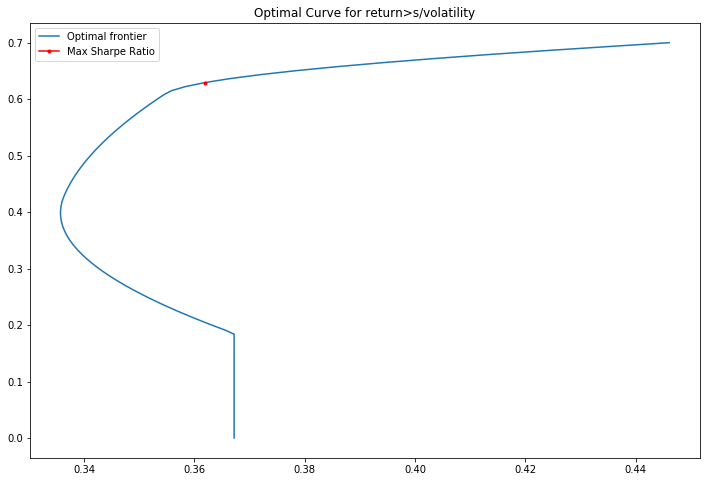

In [196]:
plt.figure(figsize=(12,8))
plt.title('Optimal Curve for return>s/volatility')
plt.plot(frontier_volatility, frontier_y, label='Optimal frontier')
plt.plot([rt_vol_sr[1]], [rt_vol_sr[0]], marker='o', markersize=3, color="red", label='Max Sharpe Ratio')
plt.legend(loc='best')

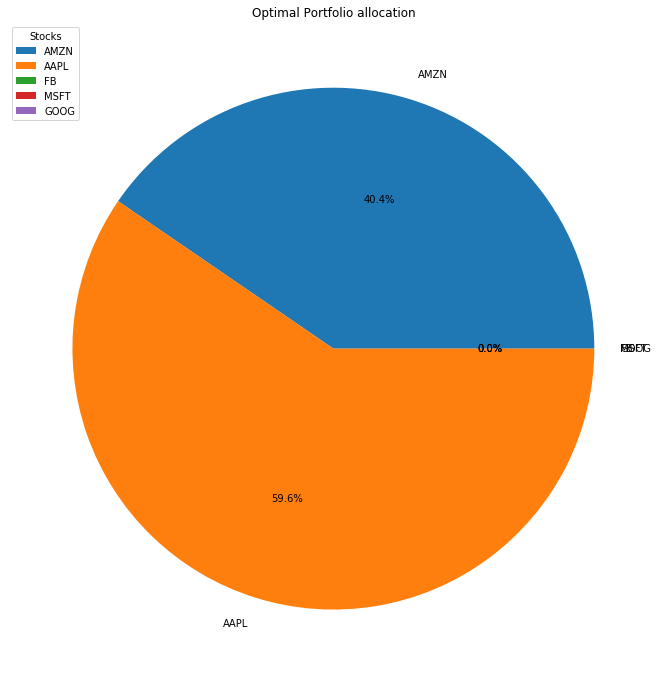

In [197]:
plt.figure(figsize=(16,12))
plt.title('Optimal Portfolio allocation')
plt.pie([float(v) for v in portfolio.values()], labels=portfolio.keys(),autopct='%1.1f%%')
plt.legend(title='Stocks', loc='best')